In [1]:
import os
import sys
import time
import datetime
from glob import glob
import math

from __future__ import division

from models import *
from utils.logger import *
from utils.utils import *
from utils.datasets import * 
from utils.parse_config import *
from test import evaluate

from terminaltables import AsciiTable
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn

import cv2
from scipy.spatial.transform import Rotation as R
import csv
import numpy as np
from numpy.linalg import inv
import open3d as o3d
from pose_metric import add_ac

import DPOD.unet_model as UNET
from DPOD.helper import load_obj

import warnings
warnings.filterwarnings(action='ignore')
#torch.backends.cudnn.benchmark = False

# Hyperparameter

In [2]:
print('Num_GPU :', torch.cuda.device_count())

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor
if device=="cuda":
    cudnn.benchmark = True
params = {
    "cpb_input_size":256,
    "bbox_input_size":512,
    #model params
    "model_def":"config/yolov3.cfg", #path to model definition file
    "class_path":"data/custom/classes.names",
    "conf_thres":0.8,
    "nms_thres":0.4,
    "ngf":64,
    "pix2pose_input_size":256,
}

Num_GPU : 2


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# model_bbox

### YOLO-v3

In [4]:
model_bbox = Darknet(params["model_def"])
model_bbox.to(device)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [5]:
model_bbox.load_state_dict(torch.load(f"checkpoints/DR/yolov3_ckpt_144.pth"))

<All keys matched successfully>

# model_correspondence_block

### Unet

In [6]:
model_cpb = UNET.UNet(
        n_channels=3, out_channels_id=2, out_channels_uv=256, bilinear=True)
model_cpb = nn.DataParallel(model_cpb)
model_cpb.to(device)

DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), p

In [7]:
model_cpb.load_state_dict(torch.load("C:/Users/IVCL/Desktop/crane/Pytorch-YOLOv3/DPOD/checkpoints/cpb_unet_aug2/cpb-190.pt"))

<All keys matched successfully>

# Evaluataion

In [8]:
def to_np(x):
    return x.data.cpu().numpy()

ry = (R.from_euler('y', 90, degrees=True)).as_dcm()
rz = (R.from_euler('z', 90, degrees=True)).as_dcm()

quat_list = []
f = open("C:/Users/IVCL/Desktop/crane/quat_real2.csv", "r")
lines = csv.reader(f)
for line in lines:
    quat_list.append(line)
f.close()

tvec_list = []
f = open("C:/Users/IVCL/Desktop/crane/tvec_real2.csv", "r")
lines = csv.reader(f)
for line in lines:
    tvec_list.append(line)
f.close()

test_pose = []
for num in range(len(quat_list)):
    ptc_rot_matrix = R.from_quat([quat_list[num][1], quat_list[num][2], quat_list[num][3], quat_list[num][0]]).as_dcm()
    ptc_rot_matrix = np.append(ptc_rot_matrix, [[0, 0, 0]], axis=0)
    tvec = np.array([tvec_list[num]]).astype('float64')
    ptc_trans_matrix = [[tvec_list[num][0]], [tvec_list[num][1]], [tvec_list[num][2]], [1.0]]
    ptc_rigid_transformation = np.append(ptc_rot_matrix, ptc_trans_matrix, axis=1).astype('float64')
    test_pose.append(ptc_rigid_transformation)
    
test_image_path = glob.glob("C:/Users/IVCL/Desktop/crane/real2_image/*.png")

dct = load_obj("./DPOD/UV-XYZ_mapping2")

fx = 595.259627
px = 255.312872
fy = 551.317594
py = 223.823052

intrinsic_matrix = np.array([[fx, 0, px], [0, fy, py], [0, 0, 1]])

camera_rigid_transformation = np.array([[ 0.9999970197677612, -8.742251367266363e-08, -0.00243386160582304, 0.006821606773883104],
        [-8.742275525719378e-08, -0.9999997615814209, -1.3877781190369556e-17, -0.018590735271573067],
        [-0.0024338611401617527, 2.1277490880322603e-10, -0.9999967813491821, 0.09084007143974304],
        [0, 0, 0, 1]])

In [9]:
def visualization(model_bbox, model_cpb, img_path, test_quat, test_tvec):
    model_bbox.eval()
    model_cpb.eval()
    
    classes = load_classes(params["class_path"])

    image = transforms.ToTensor()(Image.open(img_path).convert("RGB"))
    image = F.interpolate(image.unsqueeze(0), size=(params["bbox_input_size"]), mode="nearest").squeeze(0)
    
    with torch.no_grad():
        detections = model_bbox(image.unsqueeze(0).to(device))
        detections = non_max_suppression(detections, params["conf_thres"], params["nms_thres"])

    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(Image.open(img_path))
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(12,12))

    pred_bbox = []
    
    if detections[0] is not None:
        detections = rescale_boxes(detections[0], params["bbox_input_size"], img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
    
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            pred_bbox.append([math.floor(x1.item()), math.floor(y1.item()),
                              math.floor(x2.item()), math.floor(y2.item())])
            box_w = x2 - x1
            box_h = y2 - y1
            
            cx = math.floor((x2 + x1) / 2)
            cy = math.floor((y2 + y1) / 2)
                                   
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                       
            # Create a Rectangle patch
            if box_w > box_h:
                bbox = patches.Rectangle((cx-(box_w/2), cy-(box_w/2)), box_w, box_w, linewidth=2, edgecolor=color, facecolor="none")
                
                ax0.add_patch(bbox)
                # Add label
                ax0.text(
                    cx-(box_w/2),
                    cy-(box_w/2),
                    s=classes[0],
                    color="white",
                    verticalalignment="top", 
                    bbox={"color": color, "pad": 0},
                )
            else:
                bbox = patches.Rectangle((cx-(box_h/2), cy-(box_h/2)), box_h, box_h, linewidth=2, edgecolor=color, facecolor="none")
                ax0.add_patch(bbox)
                # Add label
                ax0.text(
                    cx-(box_h/2),
                    cy-(box_h/2),
                    s=classes[0],
                    color="white",
                    verticalalignment="top", 
                    bbox={"color": color, "pad": 0},
                )            
            
            #bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                    
    for bbox in pred_bbox:
        transform = transforms.Compose([transforms.Resize(size=(params['cpb_input_size'], params['cpb_input_size'])),
                                        transforms.ToTensor()])
       
        image = Image.open(img_path).convert("RGB")
    
        x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
        box_w = x2 - x1
        box_h = y2 - y1
        
        if box_w > box_h:
            square = box_w
        else: square = box_h

        cx = math.floor((x2 + x1) / 2)
        cy = math.floor((y2 + y1) / 2)
        
        image = image.crop((cx-square/2, cy-square/2, cx+square/2, cy+square/2))
        image = image = transforms.ToTensor()(image)
        image = F.interpolate(image.unsqueeze(0), size=params["cpb_input_size"], mode="nearest")
        mask, u_mask, v_mask = model_cpb(image)

        mask = F.interpolate(mask, square)
        u_mask = F.interpolate(u_mask, square)
        v_mask = F.interpolate(v_mask, square)
        
        mask = mask.squeeze()
        mask = to_np(torch.argmax(mask, dim=0))
        u_mask = u_mask.squeeze()
        u_mask = to_np(torch.argmax(u_mask, dim=0))
        v_mask = v_mask.squeeze()
        v_mask = to_np(torch.argmax(v_mask, dim=0))
        
        mask_512 = np.zeros((params["bbox_input_size"],params["bbox_input_size"]))
        u_mask_512 = np.zeros((params["bbox_input_size"],params["bbox_input_size"]))
        v_mask_512 = np.zeros((params["bbox_input_size"],params["bbox_input_size"]))

        for i in range(0,square):
            for j in range(0,square):
                mask_512[int(cy-square/2)+i,int(cx-square/2)+j] = mask[i,j]
                u_mask_512[int(cy-square/2)+i,int(cx-square/2)+j] = u_mask[i,j]
                v_mask_512[int(cy-square/2)+i,int(cx-square/2)+j] = v_mask[i,j]
        
        temp = torch.from_numpy(mask_512)
        upred = torch.from_numpy(u_mask_512)
        vpred = torch.from_numpy(v_mask_512)

        coord_2d = (temp == 1).nonzero(as_tuple=True)

        coord_2d = torch.cat((coord_2d[0].view(
            coord_2d[0].shape[0], 1), coord_2d[1].view(coord_2d[1].shape[0], 1)), 1)
        uvalues = upred[coord_2d[:, 0], coord_2d[:, 1]]
        vvalues = vpred[coord_2d[:, 0], coord_2d[:, 1]]
        dct_keys = torch.cat((uvalues.view(-1, 1), vvalues.view(-1, 1)), 1)
        dct_keys = tuple(dct_keys.numpy())
        
        mapping_2d = []
        mapping_3d = []
        for count, (u, v) in enumerate(dct_keys):
            if (u, v) in dct:
                mapping_2d.append(np.array(coord_2d[count]))
                mapping_3d.append(dct[(u, v)])
        # Get the 6D pose from rotation and translation matrices
        # PnP needs atleast 6 unique 2D-3D correspondences to run
        if len(mapping_2d) >= 4 or len(mapping_3d) >= 4:
            _, rvecs, tvecs, inliers = cv2.solvePnPRansac(np.array(mapping_3d, dtype=np.float32),
                                                          np.array(mapping_2d, dtype=np.float32), intrinsic_matrix, distCoeffs=None,
                                                          iterationsCount=400, reprojectionError=1.0, flags=cv2.SOLVEPNP_P3P)

        rvecs_dcm = R.from_rotvec(rvecs.squeeze()).as_dcm()
        rigid_transformation = np.append(rvecs_dcm, tvecs, axis=1)
        rigid_transformation = np.append(rigid_transformation, [[0,0,0,1]], axis=0)
        rigid_transformation_rf = inv(camera_rigid_transformation) @ rigid_transformation

        pred_quat = R.from_dcm(rz@rigid_transformation_rf[:3,:3]).as_quat()
        pred_quat = [pred_quat[3], pred_quat[0], pred_quat[1], pred_quat[2]] # convert xyzw to wxyz
        #pred_tvec = tvecs.squeeze()
        pred_tvec = rigid_transformation_rf[:3,3]
        pred_tvec = rz@[pred_tvec[0], -pred_tvec[1], -pred_tvec[2]]
        ax0.imshow(img)
        ax0.set_title("GT quat: {} \nPred quat: {}\nGT tvec {}\nPred tvec: {}".format(test_quat, pred_quat, test_tvec, pred_tvec),
                     loc='left')
        ax0.axis("off")
        
        ax1.imshow(mask_512, 'gray')
        ax1.axis("off")
        ax2.imshow(u_mask_512, 'gray')
        ax2.axis("off")
        ax3.imshow(v_mask_512, 'gray')
        ax3.axis("off")
    
    return pred_quat, pred_tvec

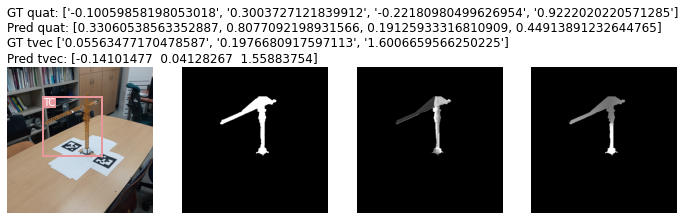

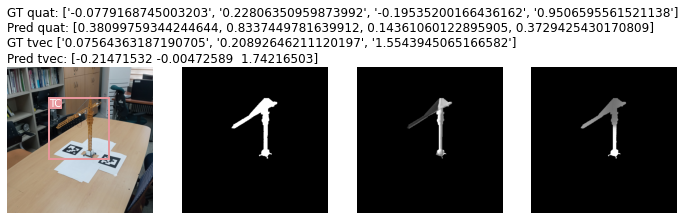

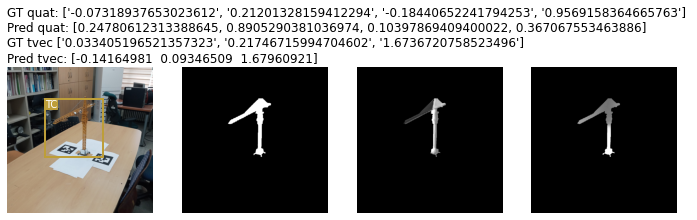

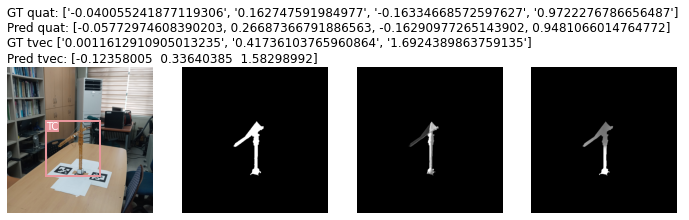

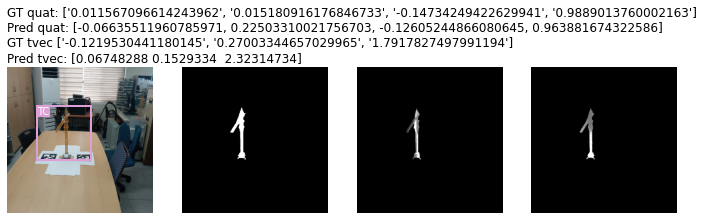

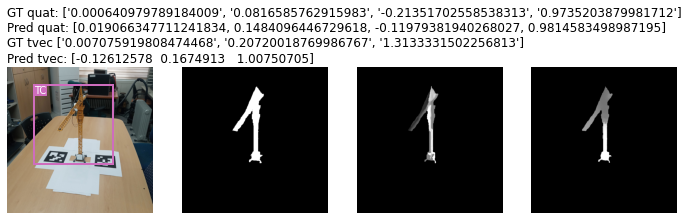

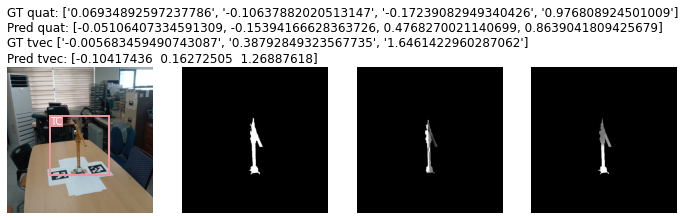

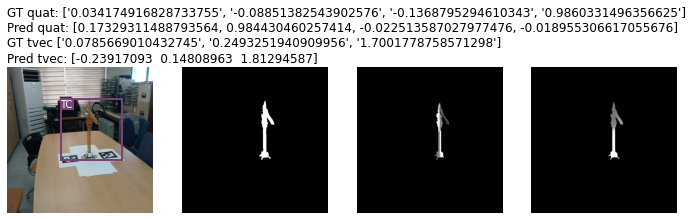

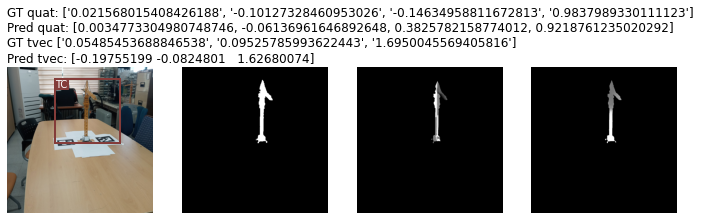

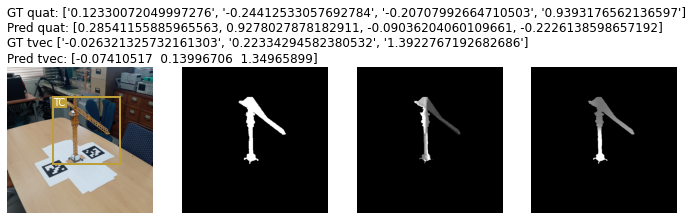

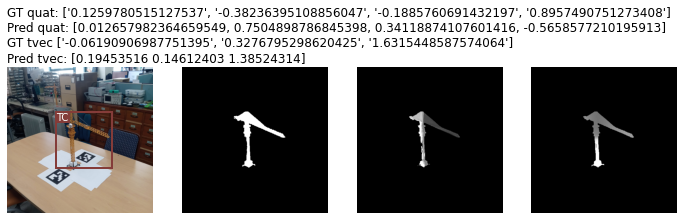

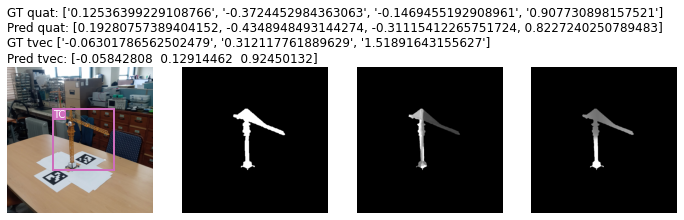

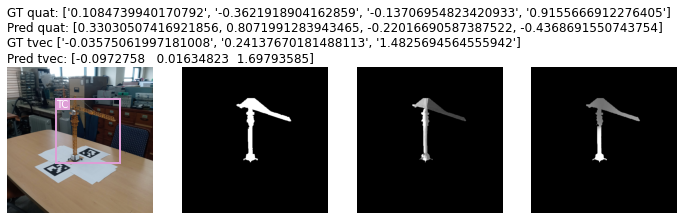

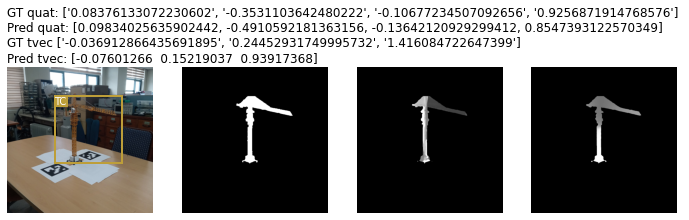

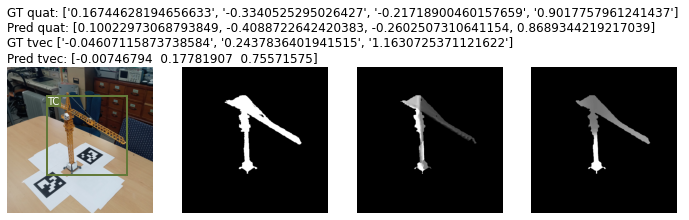

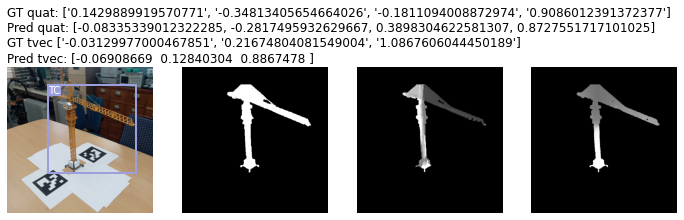

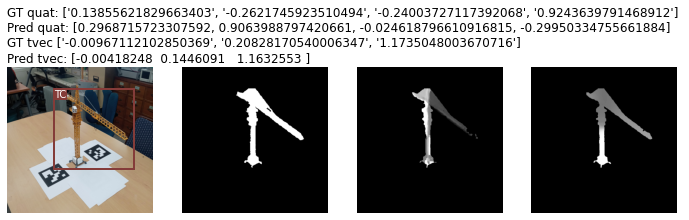

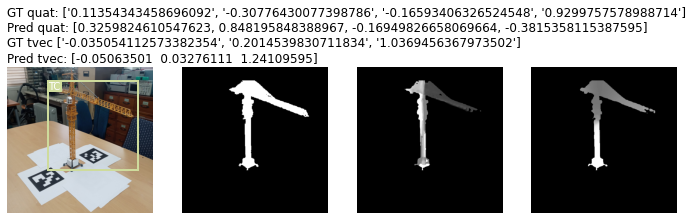

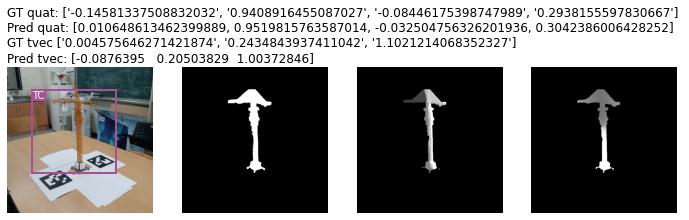

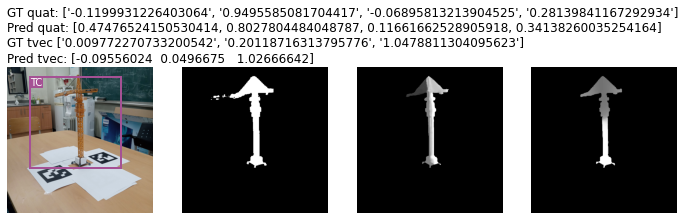

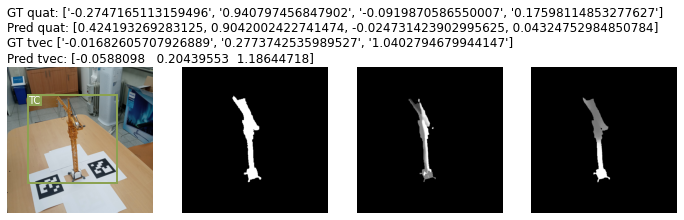

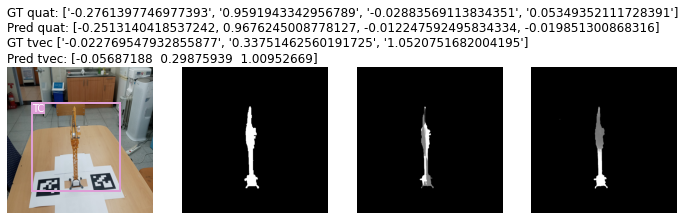

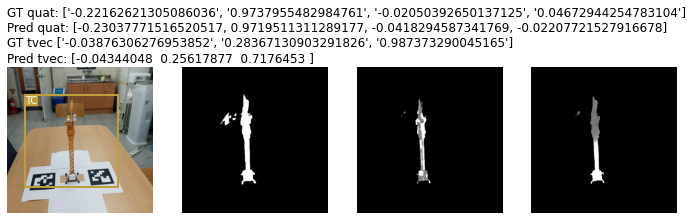

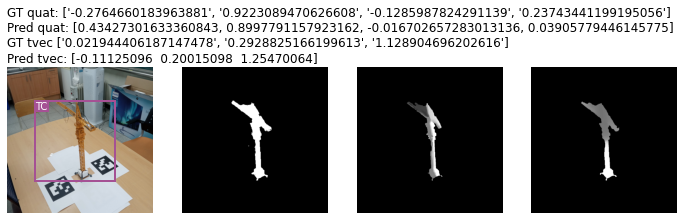

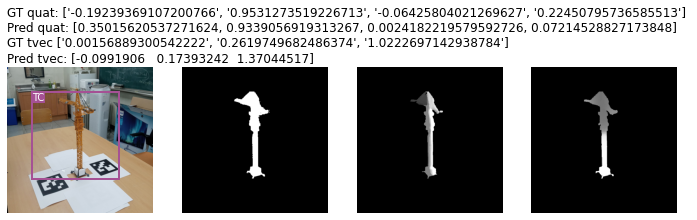

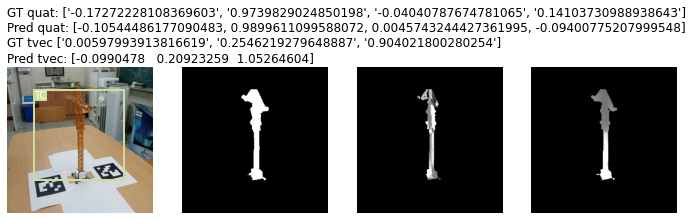

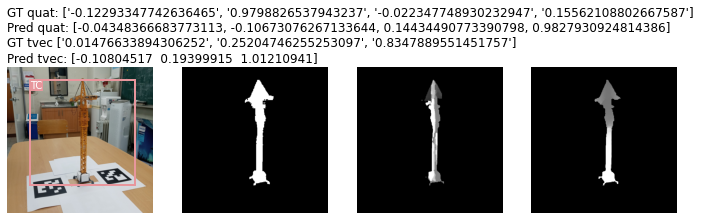

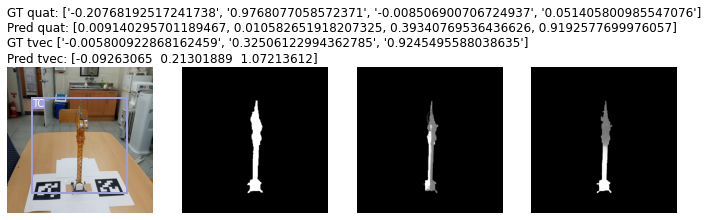

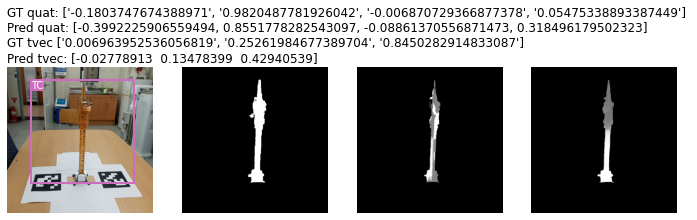

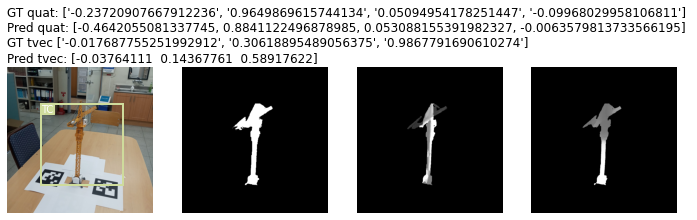

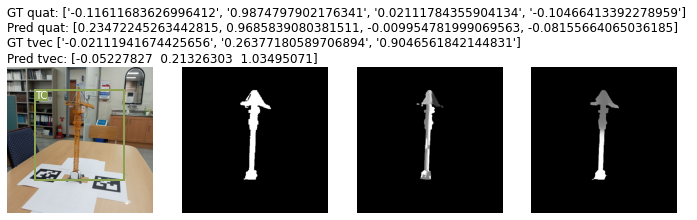

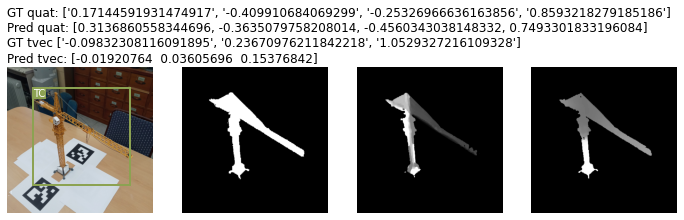

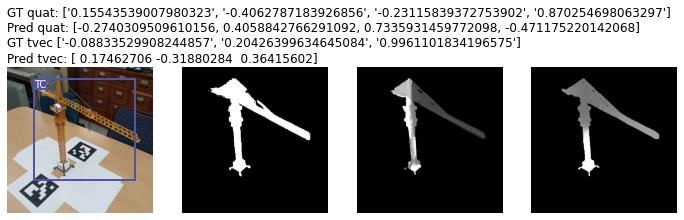

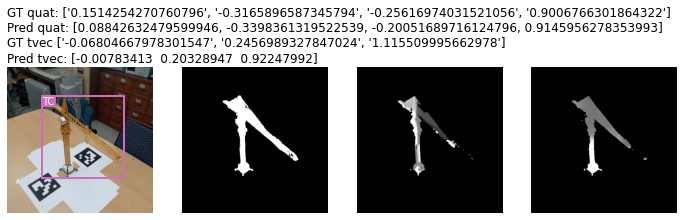

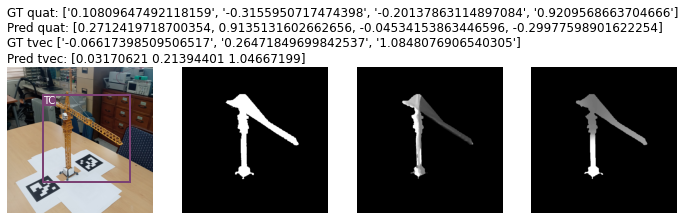

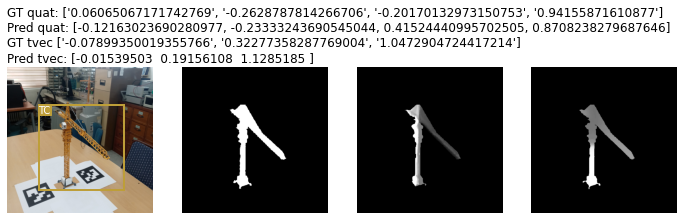

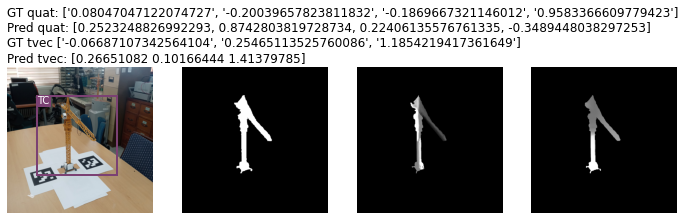

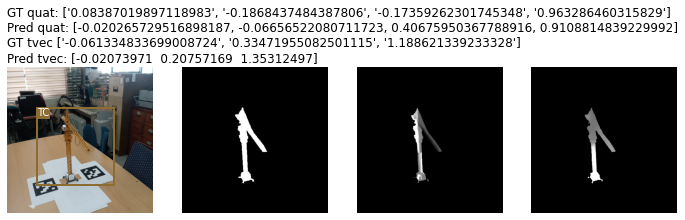

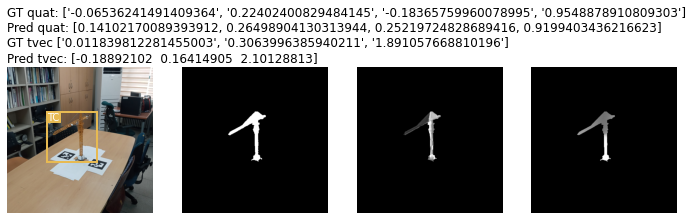

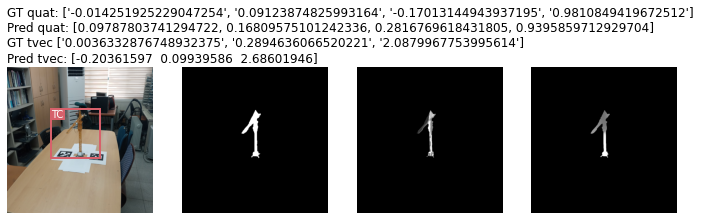

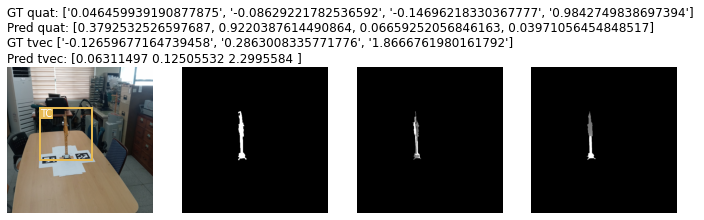

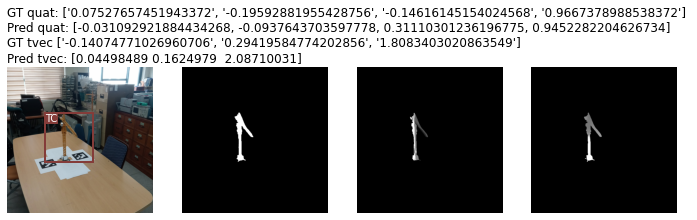

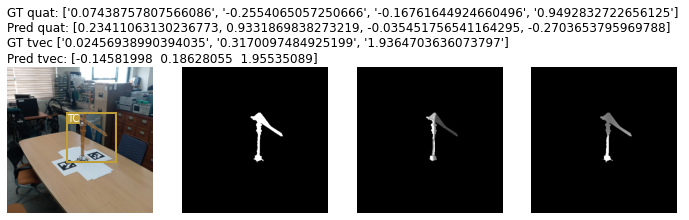

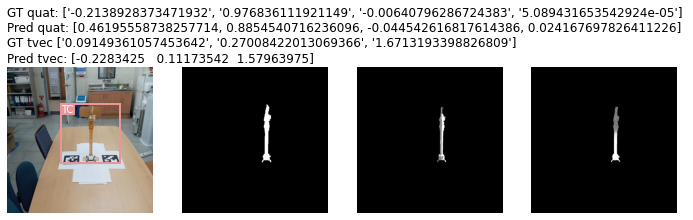

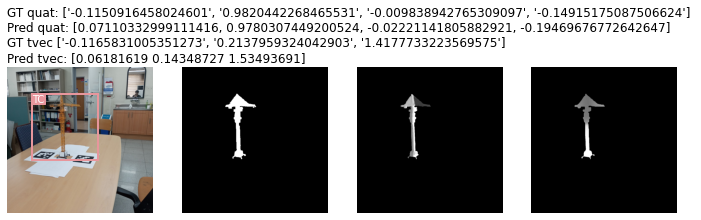

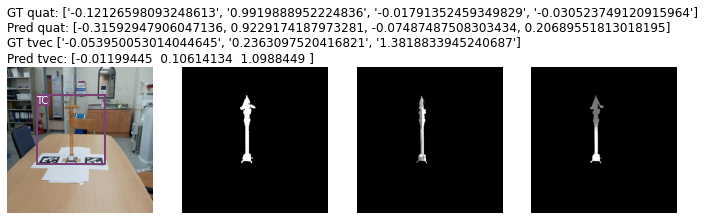

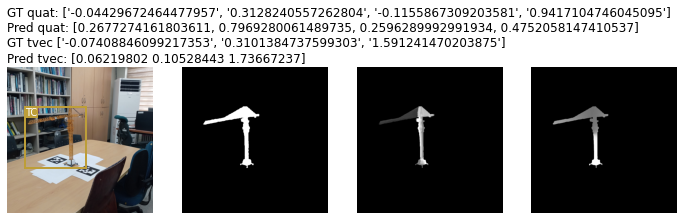

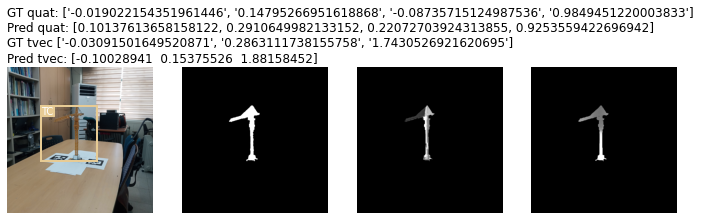

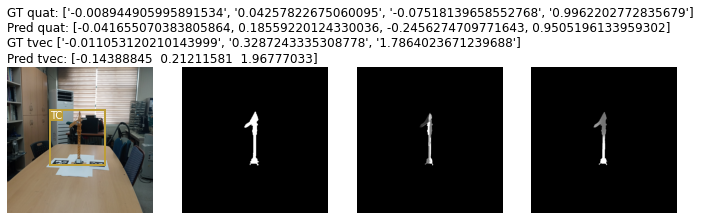

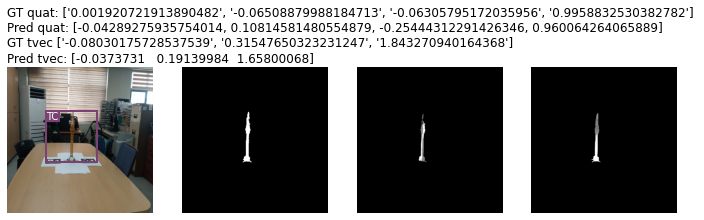

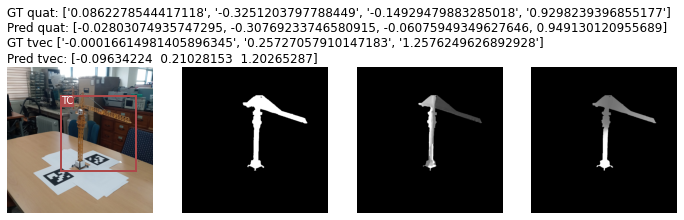

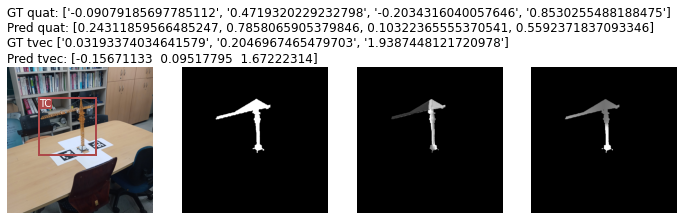

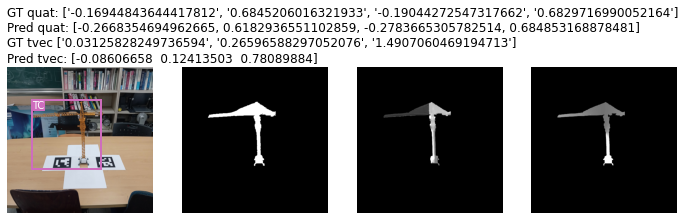

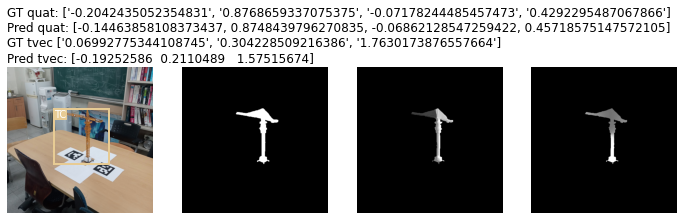

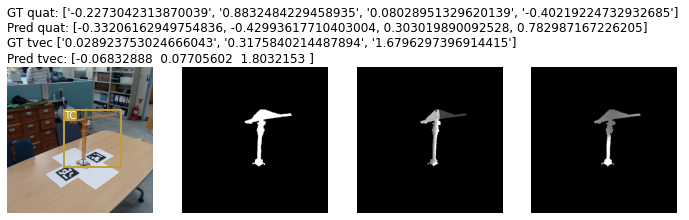

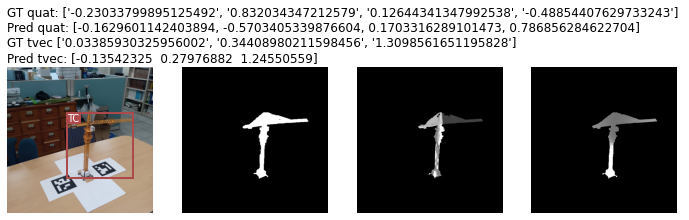

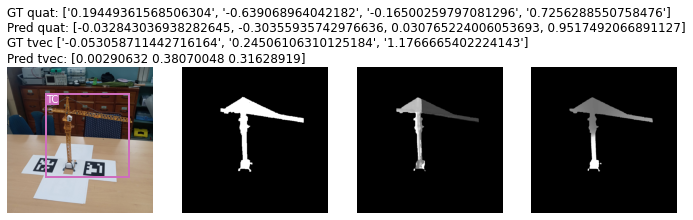

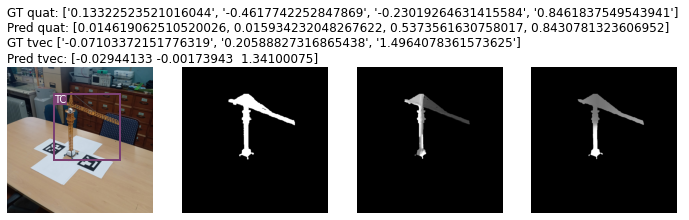

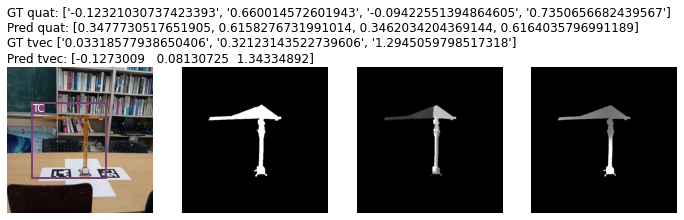

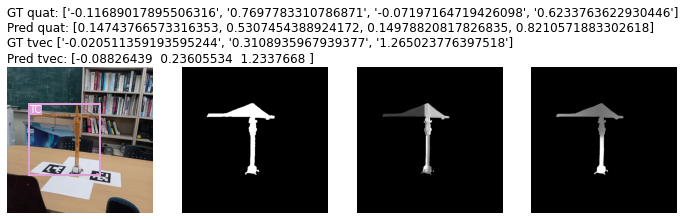

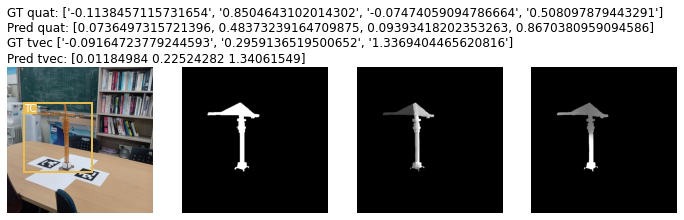

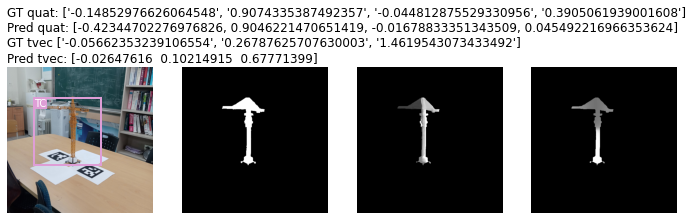

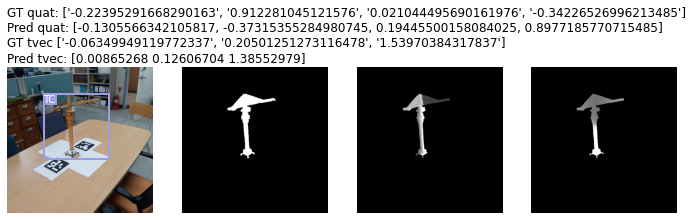

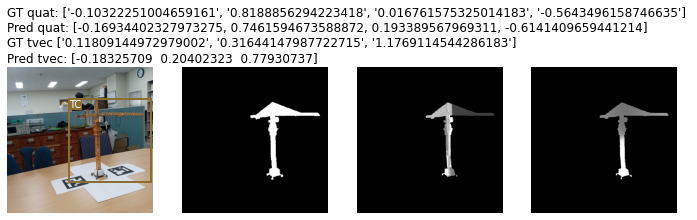

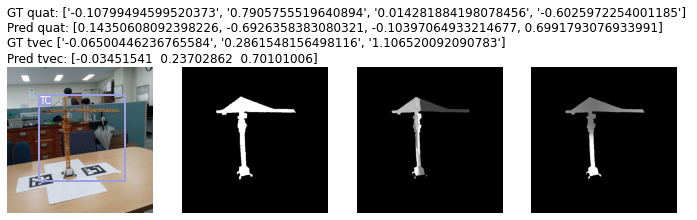

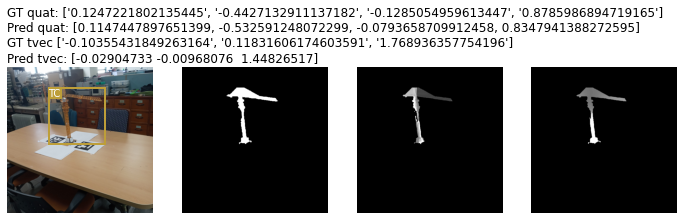

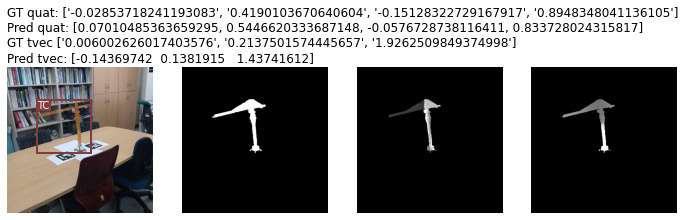

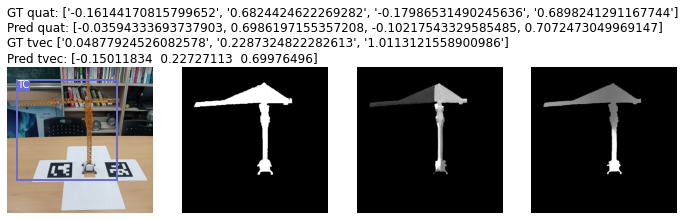

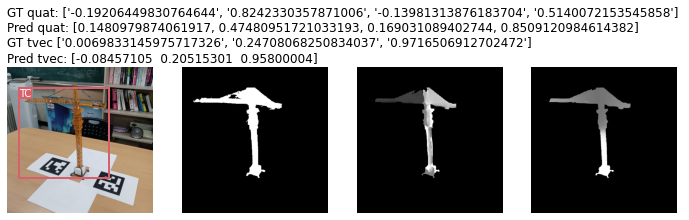

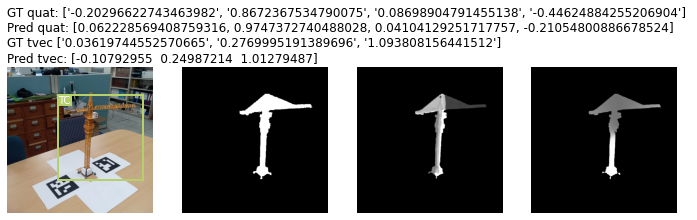

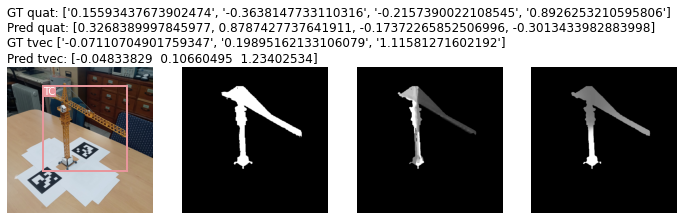

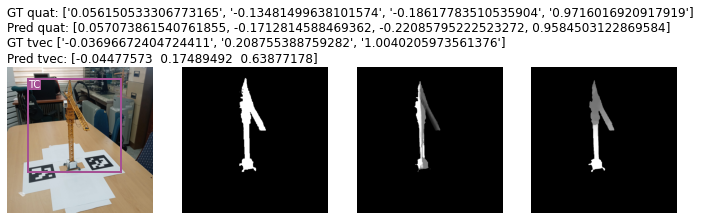

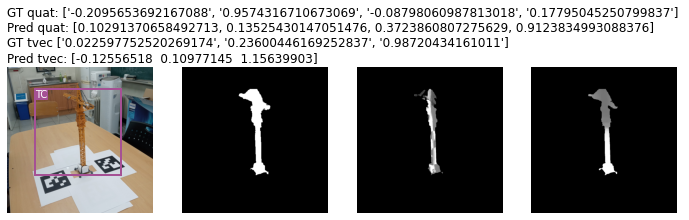

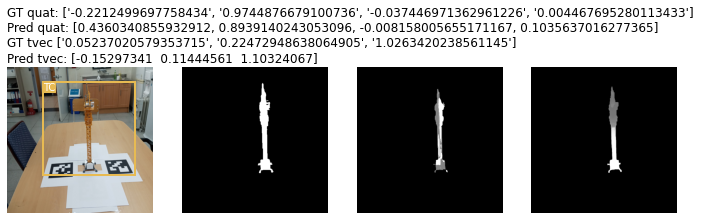

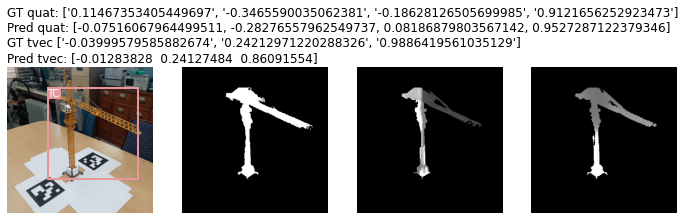

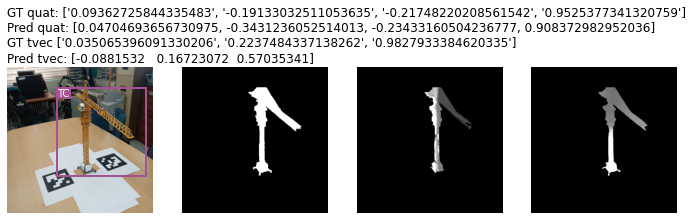

In [10]:
estimated_pose_list = []
for num in range(0, len(test_pose)):
    estimated_pose_list.append(visualization(model_bbox, model_cpb, test_image_path[num], quat_list[num], tvec_list[num]))

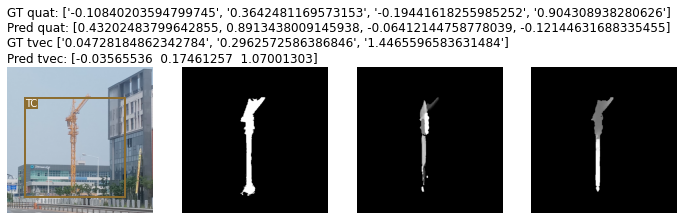

In [62]:
visualization(model_bbox, model_cpb, "./2.png",quat_list[0], tvec_list[0])

In [11]:
pcd = o3d.io.read_point_cloud("../crane2.ply")
pcd_array = np.asarray(pcd.points)

In [12]:
R_gt = R.from_quat(quat_list).as_dcm()

In [13]:
t_gt = np.array(tvec_list).astype('float64')
t_e = [estimated_pose_list[i][1].reshape(3,1) for i in range(0,len(quat_list))]

In [14]:
R_e = [R.from_quat(estimated_pose_list[num][0]).as_dcm() for num in range(0,len(estimated_pose_list))]

In [15]:
R_e_euler = [R.from_dcm(R_e[num]).as_euler('xyz',degrees=True) for num in range(0,len(R_e))]

In [16]:
R_gt_euler = [R.from_dcm(R_gt[num]).as_euler('xyz',degrees=True) for num in range(0,len(R_gt))]

In [28]:
R_sub = [abs(R_gt_euler[i] - R_e_euler[i]) for i in range(len(R_gt_euler))]

In [29]:
R_sub

[array([158.11501335,   7.62393097, 154.46504909]),
 array([152.56321478,   6.18174478, 151.23427168]),
 array([157.4505919 ,   7.04991613, 146.57078375]),
 array([166.26284272,  14.77299687, 164.08408774]),
 array([ 5.09323518, 11.49922391,  2.58931048]),
 array([12.77712194, 22.73454968,  0.53963918]),
 array([ 2.06381777,  8.04623121, 10.99655416]),
 array([24.02027772,  1.95178983, 80.28740876]),
 array([182.41199842,   7.81734874, 176.23955386]),
 array([ 6.55225997,  4.47471062, 62.54577538]),
 array([182.94041478,   2.85889947, 171.79353915]),
 array([ 75.59760487,  19.48534754, 100.08170523]),
 array([21.04616515,  3.18468699, 29.86635829]),
 array([151.63572279,   5.26320954, 144.08130804]),
 array([13.84732048, 14.86982992, 15.02719082]),
 array([0.87056034, 9.18941245, 8.79565377]),
 array([52.11713968, 10.24416862, 85.32587622]),
 array([189.68017403,   7.17288899, 174.01265468]),
 array([1.62300527e+02, 1.34490582e-01, 1.52644121e+02]),
 array([ 12.84451118,   3.55875701, 

In [32]:
for i in range(len(R_sub)):
    if R_sub[i][0] > 180:
        R_sub[i][0] = 360-R_sub[i][0]
               
    if R_sub[i][1] > 180:
        R_sub[i][1] = 360-R_sub[i][1]
               
    if R_sub[i][2] > 180:
        R_sub[i][2] = 360-R_sub[i][2]

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(R_sub[0])
plt.xlabel("Average distance threshold (m)")
plt.ylabel("Accuracy")
plt.title("UNet ADD Score")
print("ADD : {:.4f}".format(np.array(accuracy_list).sum() * 0.01 / 10))

In [33]:
plotR_sub

[array([158.11501335,   7.62393097, 154.46504909]),
 array([152.56321478,   6.18174478, 151.23427168]),
 array([157.4505919 ,   7.04991613, 146.57078375]),
 array([166.26284272,  14.77299687, 164.08408774]),
 array([ 5.09323518, 11.49922391,  2.58931048]),
 array([12.77712194, 22.73454968,  0.53963918]),
 array([ 2.06381777,  8.04623121, 10.99655416]),
 array([24.02027772,  1.95178983, 80.28740876]),
 array([177.58800158,   7.81734874, 176.23955386]),
 array([ 6.55225997,  4.47471062, 62.54577538]),
 array([177.05958522,   2.85889947, 171.79353915]),
 array([ 75.59760487,  19.48534754, 100.08170523]),
 array([21.04616515,  3.18468699, 29.86635829]),
 array([151.63572279,   5.26320954, 144.08130804]),
 array([13.84732048, 14.86982992, 15.02719082]),
 array([0.87056034, 9.18941245, 8.79565377]),
 array([52.11713968, 10.24416862, 85.32587622]),
 array([170.31982597,   7.17288899, 174.01265468]),
 array([1.62300527e+02, 1.34490582e-01, 1.52644121e+02]),
 array([12.84451118,  3.55875701, 22

In [16]:
accuracy_list = []

for ths in range(0, 1001):
    accuracy = 0
    threshold = ths * 0.001
    for num in range(0, len(quat_list)):
        accuracy = accuracy + add_ac(R_e[num], t_e[num], R_gt[num], t_gt[num], pcd_array, threshold)
    
    accuracy_list.append(accuracy / len(quat_list))

In [63]:
R_x = [R_sub[i][0] for i in range(len(R_sub))]
R_y = [R_sub[i][1] for i in range(len(R_sub))]
R_z = [R_sub[i][2] for i in range(len(R_sub))]
R_xyz_mean = [(R_x[i]+R_y[i]+R_z[i])/3 for i in range(len(R_x))]

In [70]:
np.array(R_xyz_mean).max()

124.90810576976044

In [74]:
np.array(R_xyz_mean).min()

1.3856985747948734

In [75]:
np.array(R_xyz_mean).mean()

49.88922607372564

Text(0, 0.5, 'Degree error')

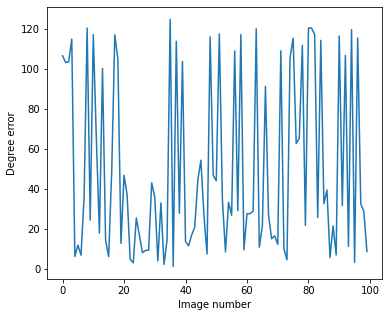

In [68]:
plt.figure(figsize=(6,5))
#plt.plot(R_x, label="x")
#plt.plot(R_y, label="y")
plt.plot(R_xyz_mean, label="z")
plt.xlabel("Image number")
plt.ylabel("Degree error")

In [18]:
csvfile=open('../ADD/ADD_unet.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(accuracy_list).reshape(len(accuracy_list),1):
    csvwriter.writerow(row)
    
csvfile.close()

In [20]:
csvfile=open('../ADD/ADD_pix2pose.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(accuracy_list).reshape(len(accuracy_list),1):
    csvwriter.writerow(row)
    
csvfile.close()

In [21]:
ADD_unet = []
f = open("../ADD/ADD_unet.csv", "r")
lines = csv.reader(f)
for line in lines:
    ADD_unet.append(line)
f.close()
ADD_unet = np.array([list(map(float, ADD_unet[i])) for i in range(0,len(ADD_unet))])

ADD_pix2pose = []
f = open("../ADD/ADD_pix2pose.csv", "r")
lines = csv.reader(f)
for line in lines:
    ADD_pix2pose.append(line)
f.close()
ADD_pix2pose = np.array([list(map(float, ADD_pix2pose[i])) for i in range(0,len(ADD_pix2pose))])

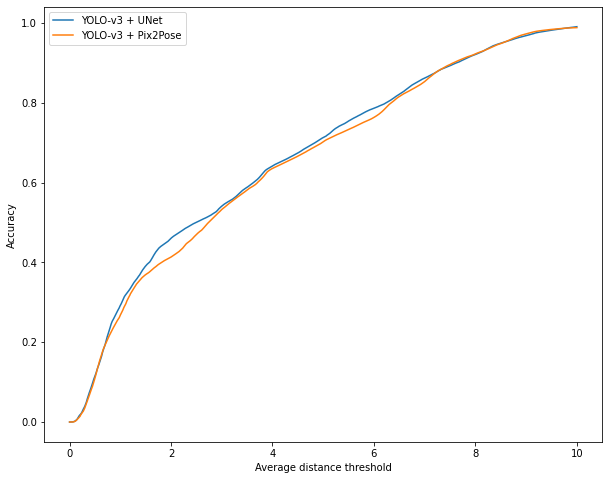

In [24]:
plt.figure(figsize=(10,8))
plt.plot([i*0.01 for i in range(0,1001)], ADD_unet, label="YOLO-v3 + UNet")
plt.plot([i*0.01 for i in range(0,1001)], ADD_pix2pose, label="YOLO-v3 + Pix2Pose")
plt.legend(loc='upper left')
plt.xlabel("Average distance threshold")
plt.ylabel("Accuracy")
plt.rc('font', size=20)
plt.savefig("./ADD.png")

In [2]:
train_DR = []
f = open("../loss/train_loss_yolov3_dr.csv", "r")
lines = csv.reader(f)
for line in lines:
    train_DR.append(line)
f.close()
train_DR = np.array([list(map(float, train_DR[i])) for i in range(0,len(train_DR))])

val_DR = []
f = open("../loss/val_loss_yolov3_dr.csv", "r")
lines = csv.reader(f)
for line in lines:
    val_DR.append(line)
f.close()
val_DR = np.array([list(map(float, val_DR[i])) for i in range(0,len(val_DR))])

train_NODR = []
f = open("../loss/train_loss_yolov3_nodr.csv", "r")
lines = csv.reader(f)
for line in lines:
    train_NODR.append(line)
f.close()
train_NODR = np.array([list(map(float, train_NODR[i])) for i in range(0,len(train_NODR))])

val_NODR = []
f = open("../loss/val_loss_yolov3_nodr.csv", "r")
lines = csv.reader(f)
for line in lines:
    val_NODR.append(line)
f.close()
val_NODR = np.array([list(map(float, val_NODR[i])) for i in range(0,len(val_NODR))])

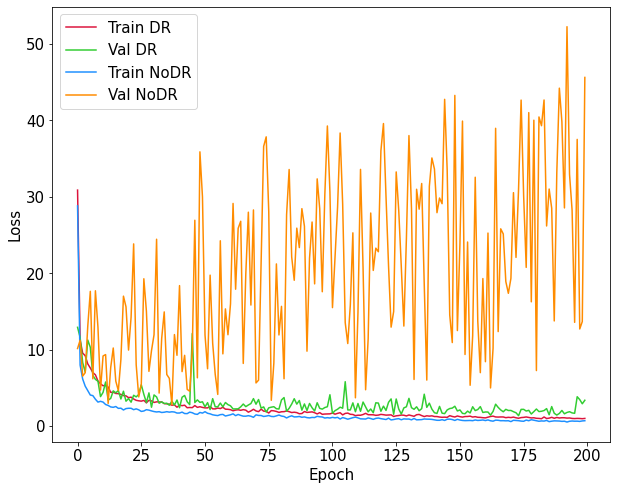

In [9]:
plt.figure(figsize=(10,8))
plt.plot(train_DR, label="Train DR", color="crimson")
plt.plot(val_DR, label="Val DR", color="limegreen")
plt.plot(train_NODR, label="Train NoDR", color="dodgerblue")
plt.plot(val_NODR, label="Val NoDR", color="darkorange")
plt.legend(loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.rc('font', size=20)
plt.savefig("./loss.png")